In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mplimg

# ML
from soap import compute_soap_density, reshape_soaps
from soap import rrw_neighbors, make_tuples

# Utilities
import h5py
import json
import project_utils as utils

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning:


The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.



# Functions

In [2]:
# 0: O-O
# 1: Si-O
# 2: Si-Si
species_pair_idx = 0
soap_idx = 0

def convert_species_idx(species_pair_idx):
    if species_pair_idx == 0:
        species_pair_label = 'OO'
    elif species_pair_idx == 1:
        species_pair_label = 'OSi'
    elif species_pair_idx == 2:
        species_pair_label = 'SiSi'
    else:
        species_pair_label = 'XX'
    return species_pair_label
 
def convert_soap_idx(soap_idx):
    if soap_idx == 0:
        soap_label = 'DEEM'
    elif soap_idx == 1:
        soap_label = 'IZA'
    else:
        soap_label = 'XXX'
    return soap_label

In [3]:
def make_plot(output, density, r_grid, p_grid, species_pair_label, neighbors=None):
    rx_grid, ry_grid, pz_grid = np.meshgrid(r_grid, r_grid, p_grid, indexing='ij')
    
    avg = np.mean(density)
    std = np.std(density)

    # TODO: take care of species_pair_idx
    fig = go.Figure(data=go.Isosurface(x=rx_grid.flatten(),
                                   y=ry_grid.flatten(),
                                   z=pz_grid.flatten(),
                                   value=density.flatten(),
                                   coloraxis='coloraxis',
                                   isomin=avg - 2.0*std,
                                   isomax=avg + 2.0*std,
                                   opacity=0.6,
                                   surface_count=4,
                                   caps=dict(x_show=False, y_show=False, z_show=False)))

    if neighbors is not None:
        atom_stencil_x_deem = np.concatenate([soap_neighbors[0][center][species_pair_idx][0].flatten() 
                                         for center in range(0, len(soap_neighbors[0]))])
        atom_stencil_y_deem = np.concatenate([soap_neighbors[0][center][species_pair_idx][1].flatten()
                                         for center in range(0, len(soap_neighbors[0]))])
        atom_stencil_z_deem = np.concatenate([soap_neighbors[0][center][species_pair_idx][2].flatten()
                                         for center in range(0, len(soap_neighbors[0]))])

        atom_stencil_x_iza = np.concatenate([soap_neighbors[1][center][species_pair_idx][0].flatten() 
                                         for center in range(0, len(soap_neighbors[1]))])
        atom_stencil_y_iza = np.concatenate([soap_neighbors[1][center][species_pair_idx][1].flatten()
                                         for center in range(0, len(soap_neighbors[1]))])
        atom_stencil_z_iza = np.concatenate([soap_neighbors[1][center][species_pair_idx][2].flatten()
                                         for center in range(0, len(soap_neighbors[1]))])

        idx_x_deem = np.concatenate([idxs_neighbors[0][center][species_pair_idx][0].flatten() 
                                for center in range(0, len(soap_neighbors[0]))])
        idx_y_deem = np.concatenate([idxs_neighbors[0][center][species_pair_idx][1].flatten() 
                                for center in range(0, len(soap_neighbors[0]))])
        idx_z_deem = np.concatenate([idxs_neighbors[0][center][species_pair_idx][2].flatten() 
                                for center in range(0, len(soap_neighbors[0]))])

        idx_x_iza = np.concatenate([idxs_neighbors[1][center][species_pair_idx][0].flatten() 
                                for center in range(0, len(soap_neighbors[1]))])
        idx_y_iza = np.concatenate([idxs_neighbors[1][center][species_pair_idx][1].flatten() 
                                for center in range(0, len(soap_neighbors[1]))])
        idx_z_iza = np.concatenate([idxs_neighbors[1][center][species_pair_idx][2].flatten() 
                                for center in range(0, len(soap_neighbors[1]))])

        fig.add_trace(go.Scatter3d(x=atom_stencil_x_deem,
                                   y=atom_stencil_y_deem,
                                   z=atom_stencil_z_deem,
                                   name=f'DEEM, {species_pair_label}',
                                   mode='markers',
                                   marker=dict(size=1,
                                               color='green'),
                                   hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}<br>(i, j): %{text}',
                                   text=['{}'.format(i) for i in zip(idx_x_deem, idx_y_deem, idx_z_deem)],
                                   showlegend=True))

        fig.add_trace(go.Scatter3d(x=atom_stencil_x_iza,
                                   y=atom_stencil_y_iza,
                                   z=atom_stencil_z_iza,
                                   name=f'IZA, {species_pair_label}',
                                   mode='markers',
                                   marker=dict(size=2,
                                               color='purple'),
                                   hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}<br>(i, j): %{text}',
                                   text=['{}'.format(i) for i in zip(idx_x_iza, idx_y_iza, idx_z_iza)],
                                   showlegend=True))

    fig.update_layout(template='plotly_white',
                      scene=dict(xaxis_title='r',
                                 yaxis_title='r\'',
                                 zaxis_title='w'),
                      legend=dict(x=0.0, y=1.0,
                                  xanchor='left', yanchor='top',
                                  itemsizing='constant'),
                      coloraxis=dict(colorscale='RdBu',
                                     colorbar=dict(title='Weights*Density')),
                      autosize=True)

    fig.write_html(f'{output}.html')
    fig.write_image(f'{output}.png')

# TODO: load densities and indices and plot

In [4]:
# Load SOAP cutoffs
with open('../../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [5]:
n_Si_deem = np.loadtxt('../../Processed_Data/DEEM_10k/n_Si.dat', dtype=int)
n_Si_iza = np.loadtxt('../../Processed_Data/IZA_226/n_Si.dat', dtype=int)

In [6]:
# Load train and test indices
idxs_deem_train = np.loadtxt('../../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../../Processed_Data/DEEM_10k/test.idxs', dtype=int)

n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

In [7]:
idxs_iza_train = np.loadtxt('../../Processed_Data/IZA_226/train.idxs', dtype=int)
idxs_iza_test = np.loadtxt('../../Processed_Data/IZA_226/test.idxs', dtype=int)

In [8]:
# Set grids
# TODO: load grids?
n_r_grid = 50
chunk_size_r = 10
r_grid = {}
for cutoff in cutoffs:
    r_grid[cutoff] = np.linspace(0.0, cutoff, n_r_grid)

n_p_grid = 50
chunk_size_p = 10
p_grid = np.linspace(-1.0, 1.0, n_p_grid)

In [9]:
# Linear model setup
n_species = 2
#group_names = {'power': ['OO', 'OSi', 'SiSi', 
#                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
#                         'OO+OSi+SiSi'], 
#               'radial': ['O', 'Si', 'O+Si']}
group_names = {'power': ['OO', 'OSi', 'SiSi'],
               'radial': ['O', 'Si']}

In [10]:
model_dir = '../../Processed_Data/Models'

deem_name = 'DEEM_10k'
iza_name = 'IZA_226'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

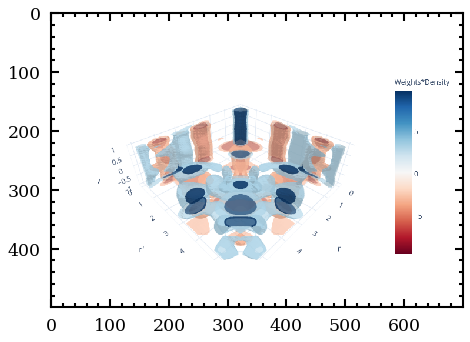

In [11]:
for cutoff in cutoffs:
    linear_dir = f'{model_dir}/{cutoff}/Linear_Models/LSVC-LPCovR'
    
    # TODO: load iza rrw indices
    # TODO: load deem rrw indices
    
    #for spectrum_type in ('power', 'radial'):
    for spectrum_type in ['power']:
        spectrum_name = spectrum_type.capitalize()        
        
        for group_name in group_names[spectrum_type]:
            deem_file = f'{deem_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'
            iza_file = f'{iza_dir}/{cutoff}/real_space_soaps_{spectrum_type}_full_avg_nonorm_{group_name}.hdf5'
            
            hdf5_deem = h5py.File(deem_file, 'r')
            hdf5_iza = h5py.File(iza_file, 'r')
            
            soaps_deem = hdf5_deem['0'][:]
            soaps_deem *= np.sum(n_Si_deem)
            soaps_iza = hdf5_deem['0'][:] * np.sum(n_Si_iza)
            soaps_avg = (soaps_iza + soaps_deem) / (np.sum(n_Si_iza) + np.sum(n_Si_deem))
            
            hdf5_deem.close()
            hdf5_iza.close()
            
            # TODO: how to handle multiple decision functions?
            #for n_cantons in (2, 4):
            for n_cantons in [2]:
                
                output = f'../../Results/{cutoff}/real_space_overlap_{n_cantons}-class_{spectrum_type}_{group_name}'
                
                weights_dir = f'{linear_dir}/{n_cantons}-Class/{spectrum_name}/{group_name}'
                weights_file = f'{weights_dir}/real_space_svc_weights.hdf5'
                
                hdf5_weights = h5py.File(weights_file, 'r')
                weights = hdf5_weights['0'][:]
                
                hdf5_weights.close()
                
                overlap = weights * soaps_avg
                
                make_plot(output, overlap.squeeze(), r_grid[cutoff], p_grid, group_name, neighbors=None)
                
                img = mplimg.imread(f'{output}.png')
                plt.imshow(img)

# SOD

In [ ]:
# Plot
species_idx = 1
rx_grid, ry_grid, tz_grid = np.meshgrid(r_grid, r_grid, p_grid, indexing='ij')
fig = go.Figure(data=go.Volume(x=rx_grid.flatten(),
                               y=ry_grid.flatten(),
                               z=tz_grid.flatten(),
                               value=density_sod[0][species_idx].flatten(),
                               isomin=0.01,
                               isomax=None,
                               opacity=0.2,
                               surface_count=20))

fig.add_trace(go.Scatter3d(x=rrw[0][species_idx][0].flatten(),
                           y=rrw[0][species_idx][1].flatten(),
                           z=rrw[0][species_idx][2].flatten(),
                           mode='markers',
                           marker=dict(size=2,
                                       color='red'),
                           hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}<br>(i, j): %{text}',
                           text=['{}'.format(i) for i in zip(idxs[0][species_idx][0].flatten(),
                                                             idxs[0][species_idx][1].flatten(), 
                                                             idxs[0][species_idx][2].flatten())]))
fig.show()